In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample
plt.style.use('ggplot')
%matplotlib widget

def load_data(dir, w, c, datetime):
    name = '%sS21s_w%d_%s_%s.npy' % (dir, w, c, datetime)
    darkname = '%s/S21_w%d_%s_%s_dark.npy' % (dir, w, c, datetime)
    freqsname = '%s/S21_w%d_%s_%s_freqs.npy' % (dir, w, c, datetime)
    # settings = '%s/S21_w%d_%s_%s_settings.txt' % (dir, w, c, datetime)
    s21s = np.load(name)
    s21dark = np.load(darkname)
    freqs = np.load(freqsname)
    return s21s, s21dark, freqs

def moving_average_filter(data, window_width):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_width:] = cumsum[window_width:] - cumsum[:-window_width]
    result = cumsum[window_width - 1:] / window_width
    result = np.concatenate((np.full(window_width - 1, result[0]), result))
    return result
            
def make_array():
    dir = 'S21s/19-10-23_w1_blue/'
    datetime = '12h16_19-10-2023'
    color = 'blue'
    w = 1
    freqsname = '%sS21_w%d_%s_%s_freqs.npy' % (dir, w, color, datetime)
    darkname = '%sS21_w%d_%s_%s_dark.npy' % (dir, w, color, datetime)
    freqs = np.load(freqsname)
    dark = np.load(darkname)
    data = np.zeros((45, 2, len(freqs)))
    for i in range(45):
        namex = '%sS21_x%dy0_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        namey = '%sS21_x0y%d_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        data[i, 0, :] = np.load(namex)
        data[i, 1, :] = np.load(namey)
    dataname = '%sS21s_w%d_%s_%s.npy' % (dir, w, color, datetime)
    np.save(dataname, data)

In [2]:
dir = 'S21s/19-10-23_w1_blue/'
s21s, dark, freqs = load_data(dir, 1, 'blue', '12h16_19-10-2023')


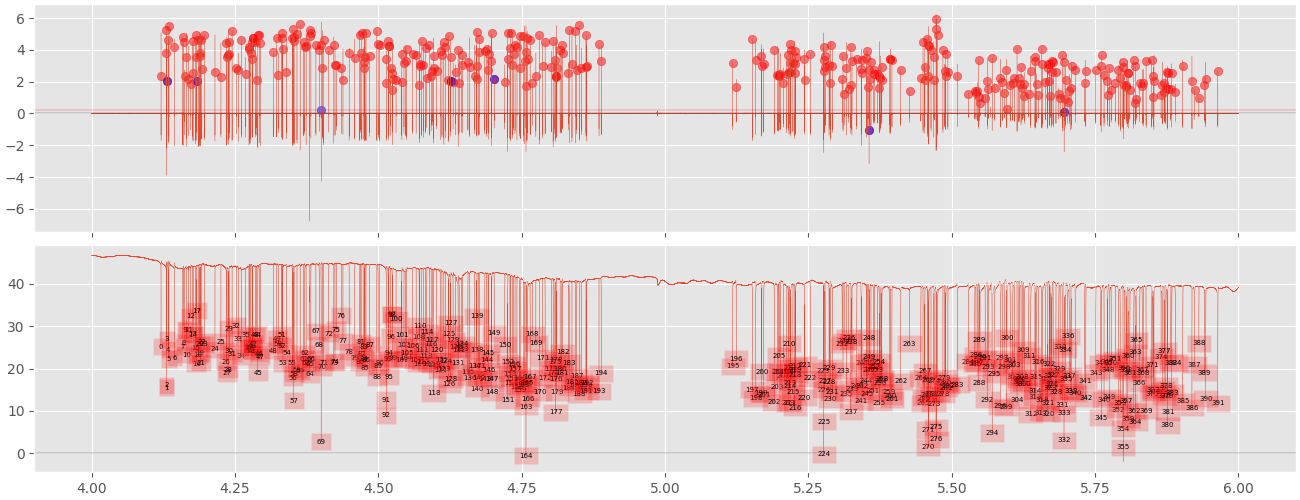

In [3]:
y = dark
width = 2
smoothed_y = moving_average_filter(y, width)
first_diff_y = np.diff(smoothed_y, 1)
smoothed_first_diff_y = moving_average_filter(first_diff_y, width)
sec_diff_y = np.diff(smoothed_first_diff_y, 1)
smoothed_sec_diff_y = moving_average_filter(sec_diff_y, width)

sel = 0.25
pks, props = find_peaks(smoothed_sec_diff_y, height=sel, prominence=sel)
real_pks = []
hs = []
for pk in pks:
    h = y[pk]  
    x = pk 
    new_x = x-1 
    new_h = y[new_x]
    while new_h < h:
        x = new_x
        h = new_h
        new_x -= 1
        new_h = y[new_x]
    real_pks.append(x)
    hs.append(h)
pks = np.array(real_pks)
# hs = np.array(hs)
hs = smoothed_sec_diff_y[real_pks]

stds = 2
pks_diff = pks[1:]-pks[:-1]
mean_pks_diff = np.mean(pks_diff)
std_mean_pks_diff = np.std(pks_diff)
close_pks = pks_diff < mean_pks_diff - stds*std_mean_pks_diff
hs_diff = hs[1:]-hs[:-1]
mean_hs_diff = np.mean(hs_diff)
std_mean_hs_diff = np.std(hs_diff)
low_hs = hs_diff < mean_hs_diff - stds*std_mean_hs_diff
sketchy_pks = pks[1:][low_hs + close_pks]

remove = [69, 295]
pks = np.delete(pks, remove)
hs = np.delete(pks, remove)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(13, 5), constrained_layout=True)
ax['a'].plot(freqs[1:-1], smoothed_sec_diff_y, lw=.2)
ax['a'].scatter(freqs[1:-1][pks], smoothed_sec_diff_y[pks], color='r', alpha=0.5)
ax['a'].scatter(freqs[1:-1][sketchy_pks], smoothed_sec_diff_y[sketchy_pks], color='b', alpha=0.5)
ax['a'].axhline(0, 0, 1, color='k', lw=.2)
ax['a'].axhline(sel, 0, 1, color='r', lw=.2)
for i, label in enumerate(range(len(pks))):
    ax['b'].text(freqs[pks[i]], y[pks[i]], str(label), ha='center', va='center', fontsize=5, bbox=dict(facecolor='red', alpha=0.2))
ax['b'].plot(freqs, y, lw=.2)
# ax['b'].scatter(freqs[pks], y[pks], color='r', alpha=0.5)
ax['b'].axhline(0, 0, 1, color='k', lw=.2)
plt.show()


In [4]:
nr_scans = s21s.shape[0]
nr_pks = len(pks)
dark_heights = dark[pks]
height_diffs = np.zeros((nr_scans, nr_scans, nr_pks))
for i in range(nr_scans):
    scanx = s21s[i, 0, :]
    scany = s21s[i, 1, :]
    scanx_heights = scanx[pks]
    scany_heights = scany[pks]
    height_diffx = dark_heights - scanx_heights
    height_diffy = dark_heights - scany_heights
    height_diffs[i, 0, :] = height_diffx
    height_diffs[i, 1, :] = height_diffy



In [ ]:
pos = np.arange(nr_scans)
min = np.min(s21s)
max = np.max(s21s)
dips = np.arange(nr_pks)
coords = np.full((nr_scans, nr_scans), -1)
nr_clashes = 0
for i in dips:
    scanx = height_diffs[:, 0, i]
    scany = height_diffs[:, 1, i]
    idxx = np.argmin(scanx)
    pkx = np.amin(scanx)
    peakx = scanx < (pkx - pkx/2)
    idxx = int(np.mean(pos[peakx]))
    idxy = np.argmin(scany)
    pky = np.amin(scany)
    peaky = scany < (pky - pky/2)
    idxy = int(np.mean(pos[peaky]))
    id = coords[idxx, idxy]
    if (id == -1) and (pkx < 0) and (pky < 0):
        coords[idxx, idxy] = i
        if i <=3:
            fig, ax = plt.subplot_mosaic('a')
            ax['a'].plot(pos, scanx, lw=.5)
            ax['a'].plot(pos, peakx, lw=.5)
            ax['a'].set_title('%s, X' % (i))
            ax['a'].scatter(pos[idxx], scanx[idxx])
            ax['a'].set_ylim([-30, 10])
            fig, ax = plt.subplot_mosaic('a')
            ax['a'].plot(pos, scany, lw=.5)
            ax['a'].plot(pos, peaky, lw=.5)
            ax['a'].set_title('%s, Y' % (i))
            ax['a'].scatter(pos[idxy], scany[idxy])
            ax['a'].set_ylim([-30, 10])
    elif id != -1:
        print('clash', id)
    else:
        print('weird', id)
        nr_clashes += 1
        print('clash %d' % nr_clashes)
        print(i, idxx, idxy)
        fig, ax = plt.subplot_mosaic('a')
        ax['a'].plot(pos, scanx, lw=.5)
        ax['a'].plot(pos, peakx, lw=.5)
        ax['a'].set_title('%s' % (i))
        ax['a'].scatter(pos[idxx], scanx[idxx])
        ax['a'].set_ylim([min-2, max+2])
        ax['a'].plot(pos, s21s[:, 0, id], lw=.5, ls='--')
        ax['a'].plot(pos, s21s[:, 1, id], lw=.5)
Z = coords
fig, ax = plt.subplots()
plt.imshow(Z, origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Color Plot Example')
ax.grid(False)
plt.show()


array([[  1,   1],
       [  1,   2],
       [ 57,   1],
       [ 57,   2],
       [ 69,   1],
       [ 69,   2],
       [ 91,   1],
       [ 91,   2],
       [104,   1],
       [104,   2],
       [164,   1],
       [164,   2],
       [224,   1],
       [224,   2],
       [225,   1],
       [225,   2],
       [321,   1],
       [321,   2],
       [332,   1],
       [332,   2],
       [354,   1],
       [354,   2],
       [381,   1],
       [381,   2]], dtype=int64)

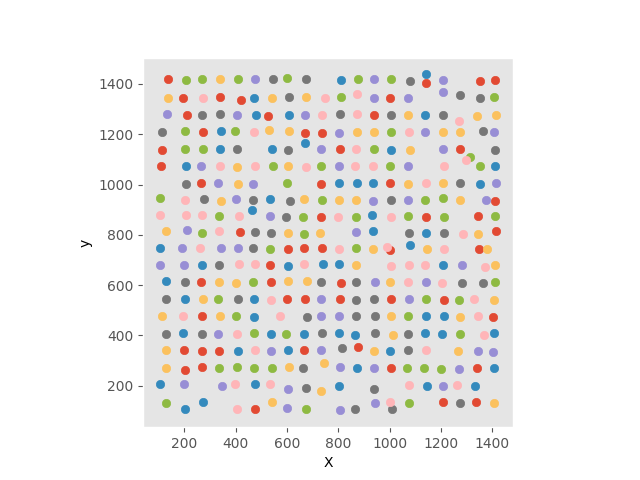

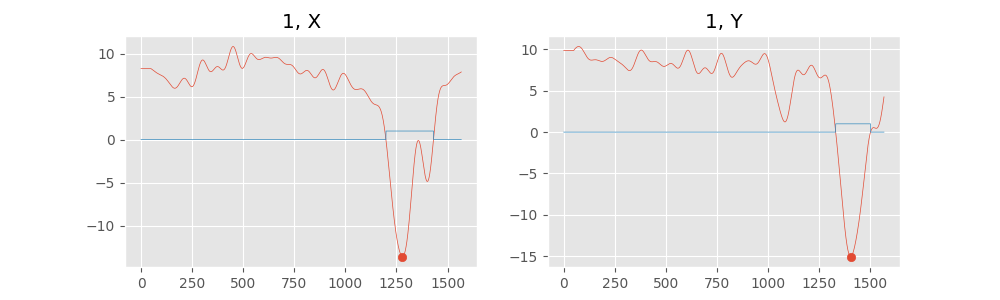

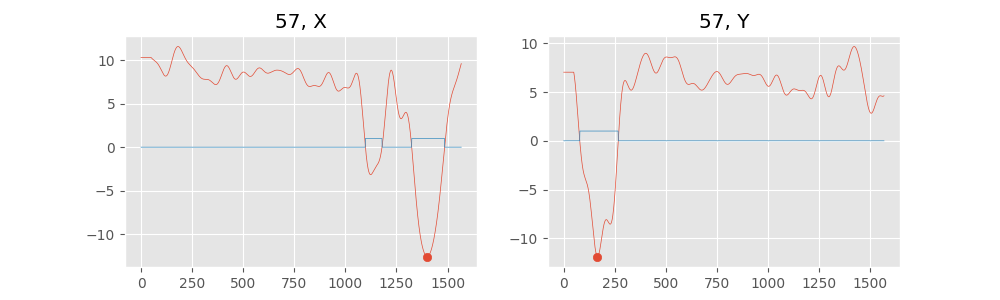

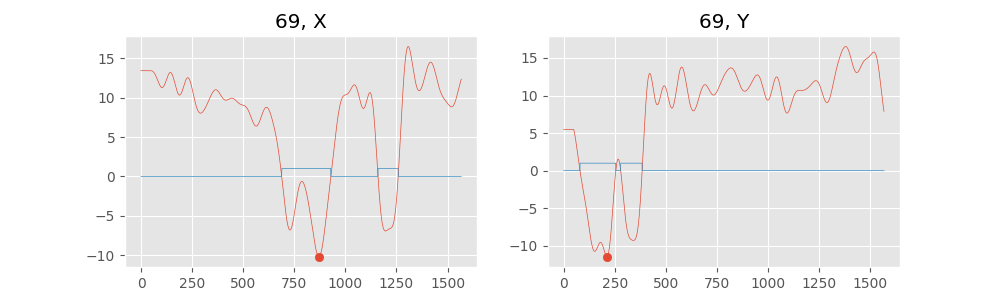

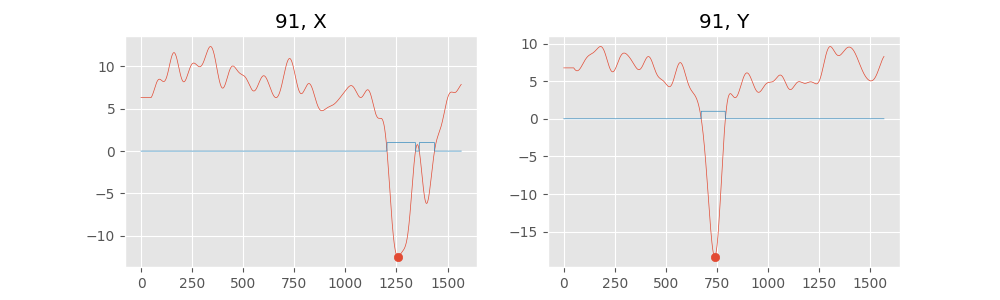

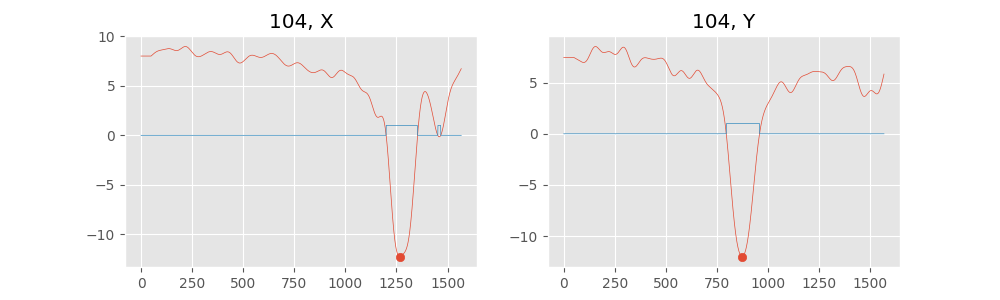

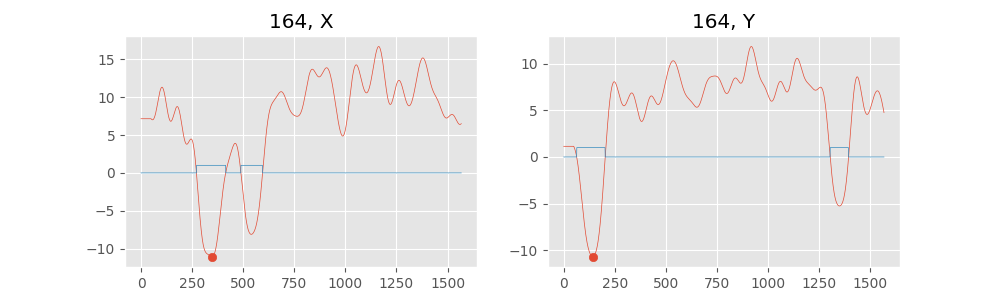

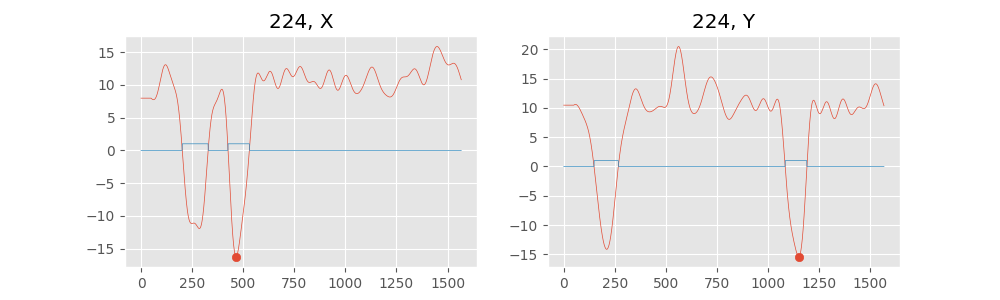

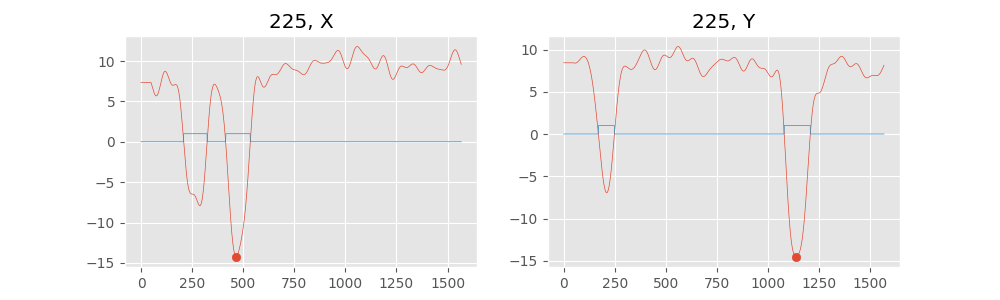

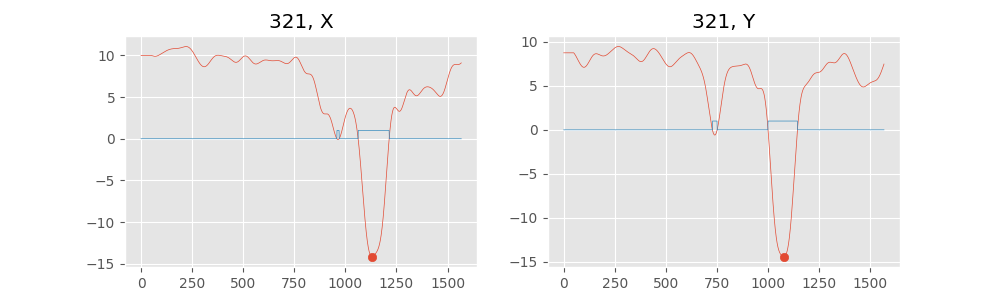

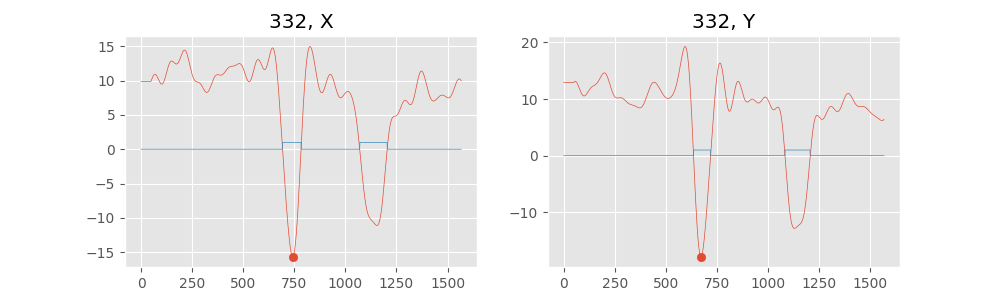

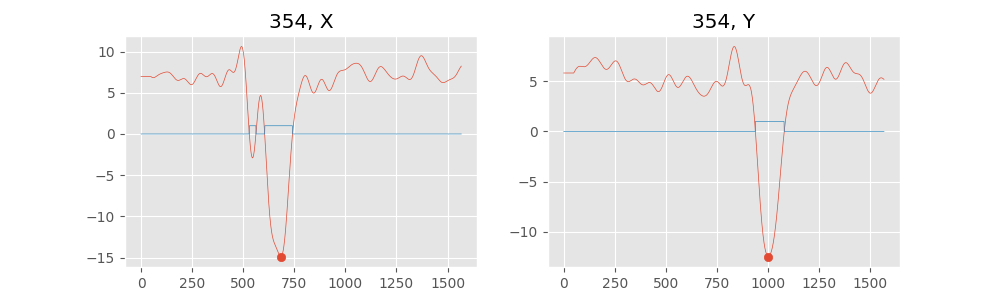

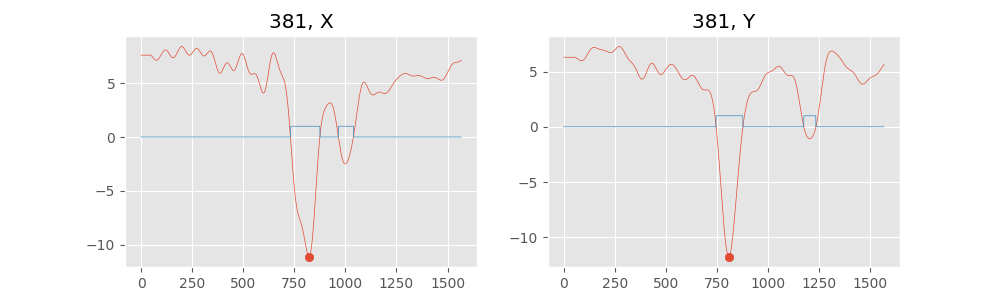

In [39]:
min = np.min(s21s)
max = np.max(s21s)

coords = np.full((nr_pks, 3), -1)  # 2 columns: f0, x, y
coords[:, 0] = freqs[pks]
nr_clashes = 0
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.grid(False)
height_diffs = resample(height_diffs, 4*nr_pks, axis=0)
nr_scans = height_diffs.shape[0]
pos = np.arange(nr_scans)
dips = np.arange(nr_pks)
for i in dips:
    scanx = height_diffs[:, 0, i]
    scany = height_diffs[:, 1, i]
    scanx = moving_average_filter(scanx, 50)
    scany = moving_average_filter(scany, 50)
    meanx = np.mean(scanx)
    stdx = np.std(scanx)
    meany = np.mean(scany)
    stdy = np.std(scany)
    scanx -= meanx - stdx
    scany -= meany - stdy

    scanxpks, props = find_peaks(-scanx, height=0, prominence = 2)
    scanypks, props = find_peaks(-scanx, height=0, prominence = 2)
    
    peakx = scanx < 0
    peaky = scany < 0

    pkx = np.amin(scanx)
    pky = np.amin(scany)
    
    if (len(scanxpks)==1) and (len(scanypks)==1):
        idxy = np.mean(pos[peaky])
        idxx = np.mean(pos[peakx])
        coords[i, 1:] = idxx, idxy
        ax.scatter(idxx, idxy)
        ax.set_xlabel('X')
        ax.set_ylabel('y')
    else:   
        idxx = np.argmin(scanx)
        idxy = np.argmin(scany)
        # coords[i, 1:] = idxx, idxy
        # ax.scatter(idxx, idxy)
        fig, axes = plt.subplot_mosaic('ab', figsize=(10, 3))
        axes['a'].plot(pos, scanx, lw=.5)
        axes['a'].plot(pos, peakx, lw=.5)
        axes['a'].set_title('%s, X' % (i))
        axes['a'].scatter(idxx, pkx)
        axes['b'].plot(pos, scany, lw=.5)
        axes['b'].plot(pos, peaky, lw=.5)
        axes['b'].set_title('%s, Y' % (i))
        axes['b'].scatter(idxy, pky)
np.argwhere(coords==-1)



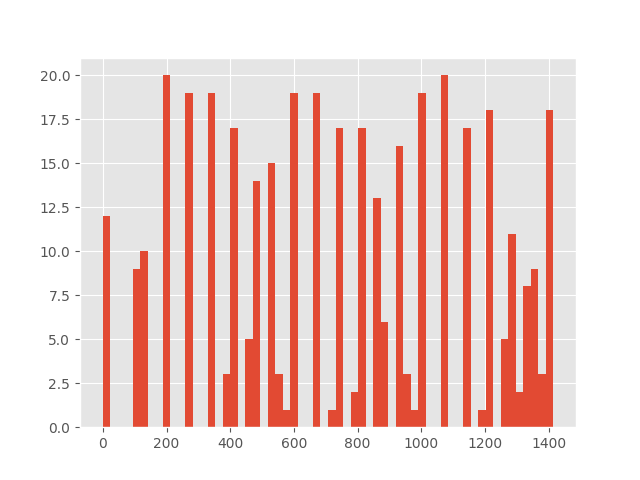

In [46]:
fig, ax = plt.subplots()
bars = ax.hist(coords[:, 1], bins=60)

In [42]:
bars

(array([12.,  0.,  0.,  0.,  8., 10.,  0.,  4., 12.,  0.,  0., 19.,  1.,
         0., 19.,  0.,  8., 12.,  0., 19.,  0.,  0., 20.,  0.,  0., 20.,
         0.,  0., 19.,  0.,  4., 16.,  0., 17.,  1.,  0., 18.,  1.,  0.,
        20.,  0., 17.,  0.,  0., 18.,  1.,  1., 16.,  1.,  0., 20.,  0.,
         1., 19.,  0.,  1., 17.,  1.,  3., 16.]),
 array([-1.00000000e+00,  2.29833333e+01,  4.69666667e+01,  7.09500000e+01,
         9.49333333e+01,  1.18916667e+02,  1.42900000e+02,  1.66883333e+02,
         1.90866667e+02,  2.14850000e+02,  2.38833333e+02,  2.62816667e+02,
         2.86800000e+02,  3.10783333e+02,  3.34766667e+02,  3.58750000e+02,
         3.82733333e+02,  4.06716667e+02,  4.30700000e+02,  4.54683333e+02,
         4.78666667e+02,  5.02650000e+02,  5.26633333e+02,  5.50616667e+02,
         5.74600000e+02,  5.98583333e+02,  6.22566667e+02,  6.46550000e+02,
         6.70533333e+02,  6.94516667e+02,  7.18500000e+02,  7.42483333e+02,
         7.66466667e+02,  7.90450000e+02,  8.14433

In [43]:
for i in range(20):
    if i == 0:
        print(np.sum(bars[0][i:i+1]))
    if i == 19:
        

12.0
0.0
8.0
18.0
18.0
14.0
16.0
16.0
12.0
19.0
20.0
20.0
20.0
19.0
27.0
20.0
20.0
31.0
19.0
19.0
